In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline

from nltk.stem import WordNetLemmatizer
from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords

In [6]:
df = pd.read_csv('../data/posts.csv')
df.head()

,title,selftext,author_fullname,created_utc,subreddit
0,Jake here thinks we use abortion as a girls ni...,NaN,t2_h4yrdcak,1645731680,prochoice
1,How Black Feminists Defined Abortion Rights—As...,NaN,t2_wkk8q,1645729017,prochoice
2,US-linked anti-abortion centre targeting women...,NaN,t2_bkt67o0k,1645714835,prochoice
3,I catch myself sometimes looking for the proli...,Anyone else ever do that? I think *Pfb* (pro f...,t2_47mcn020,1645655368,prochoice
4,France extends abortion limit to 14 weeks,NaN,t2_n6epl,1645650196,prochoice


In [7]:
df['prolife_or_not'] = df['subreddit'].map({'prolife':1, 'prochoice':0})
# Creating this for EDA - make legends readable

## CountVectorizer on title, subtext separately

In [8]:
cv = CountVectorizer(stop_words='english',
                       min_df=2,
                       max_df=.95,
                       ngram_range=(1,3),
                       max_features=7000)
cv.fit(df['title'])

title_vectors = cv.transform(df['title'])
#X_test_cvec = cvec.transform(X_test)
title_df = pd.DataFrame(title_vectors.todense(), columns=cv.get_feature_names())

In [9]:
title_df.shape

(9986, 7000)

In [10]:
df[df['title'].str.contains('pro-')]

,title,selftext,author_fullname,created_utc,subreddit,prolife_or_not
9,Let's say there's a person who supports aborti...,The answers that have the little asterisk mean...,t2_guxlo35u,1645573429,prochoice,0
11,It's interesting how pro-lifers say that most ...,That logic is so strange... You tell a woman w...,t2_dwaua2ch,1645563299,prochoice,0
27,Why are you pro-choice?,"I'm a pro-lifer, and I want to hear the other ...",t2_4cnfydq4,1645499230,prochoice,0
79,pro-lifer here to argue my opionon,[removed],t2_jqa5xhlu,1644952897,prochoice,0
84,Need fellow pro-choicers to answer some questi...,Im writing a paper for school on abortion and ...,t2_8x8w6aeq,1644927044,prochoice,0
...,...,...,...,...,...,...
9937,Are there any pro-life Jews on this subreddit?...,NaN,t2_cpwihepv,1630068404,prolife,1
9953,do you have any hope for the future of the pro...,"truth be told, I don't. with the onset of left...",t2_akti2ydn,1629978469,prolife,1
9964,The Wish List (political organization) [List o...,NaN,t2_1q7ke3th,1629914996,prolife,1
9968,If you're on Instagram (or Facebook or Twitter...,NaN,t2_85oaok68,1629900204,prolife,1


### Adding vectorizer that takes hyphenated words beginning with 'pro-'

In [11]:
cv_pro = CountVectorizer(token_pattern='pro\-\w+')

compound_vectors = cv_pro.fit_transform(df['title'])
title_compound_df = pd.DataFrame(compound_vectors.todense(), columns = cv_pro.get_feature_names())

title_vectors_with_compounds = pd.concat([title_df, title_compound_df], axis=1)

title_vectors_with_compounds['prolife_or_not'] = df['prolife_or_not']
title_vectors_with_compounds.head()

,00,000,01,10,10 weeks,100,1000,10k,11,11 year,...,pro-murdering,pro-natalist,pro-nothing,pro-planet,pro-science,pro-selfishness,pro-unborn,pro-vaccine,pro-woman,prolife_or_not
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


<AxesSubplot:title={'center':'Top words in post titles in pro-life subreddit'}>

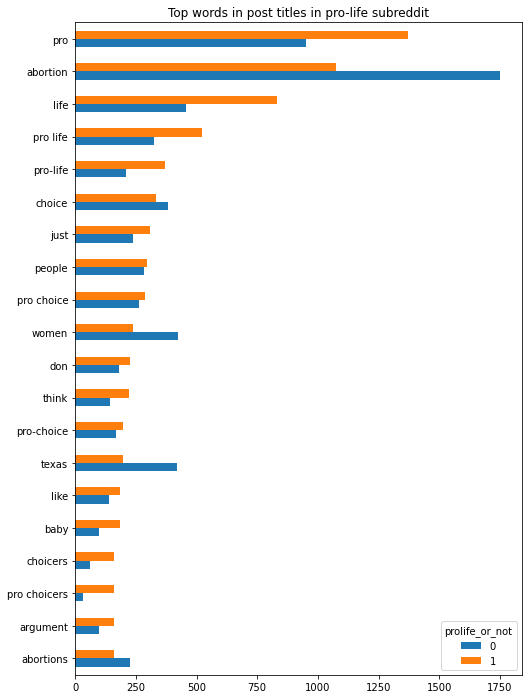

In [12]:
# most common words in prolife subreddit
# barh code from NLP II lecture

title_vectors_with_compounds.groupby('prolife_or_not').sum().T.sort_values(1).tail(20).plot.barh(figsize=(8,12), title='Top words in post titles in pro-life subreddit')


<AxesSubplot:title={'center':'Top words in post titles in pro-choice subreddit'}>

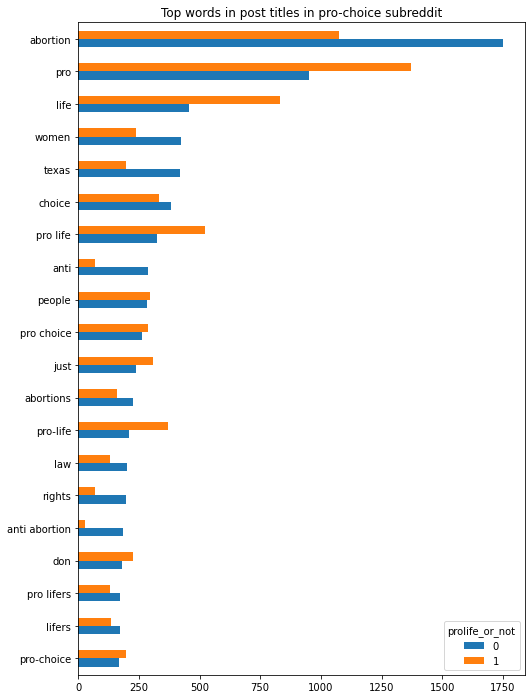

In [13]:
# top pro-choice words

title_vectors_with_compounds.groupby('prolife_or_not').sum().T.sort_values(0).tail(20).plot.barh(figsize=(8,12), title='Top words in post titles in pro-choice subreddit')


In [14]:
# same as above but on selftext

df_selftext = df.dropna()
df_selftext.index

Int64Index([   3,    9,   11,   12,   18,   21,   23,   24,   26,   27,
            ...
            9958, 9963, 9967, 9971, 9975, 9976, 9977, 9979, 9981, 9982],
           dtype='int64', length=3978)

In [18]:
cv_self = CountVectorizer(stop_words='english',
                       min_df=2,
                       max_df=.95,
                       ngram_range=(1,3),
                       max_features=7000)
self_vectors = cv_self.fit_transform(df_selftext['selftext'])
self_vectors_df = pd.DataFrame(self_vectors.todense(), columns=cv_self.get_feature_names(), index=df_selftext.index)

cv_self_compounds = CountVectorizer(token_pattern='pro\-\w+')
self_compound_vectors = cv_self_compounds.fit_transform(df_selftext['selftext'])
self_compound_df = pd.DataFrame(self_compound_vectors.todense(), columns = cv_self_compounds.get_feature_names(), index=df_selftext.index)

selftext_vectors_with_compounds = pd.concat([self_vectors_df, self_compound_df], axis=1)
selftext_vectors_with_compounds['prolife_or_not'] = df_selftext['prolife_or_not']
selftext_vectors_with_compounds.head()


,000,000 women,01,02,03,04,05,06,07,08,...,pro-susan,pro-theresa,pro-unemployment,pro-vaccine,pro-vanessa,pro-veganism,pro-war,pro-woman,pro-women,prolife_or_not
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
11,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
12,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
18,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [19]:
selftext_vectors_with_compounds.groupby('prolife_or_not').sum().T.sort_values(1).tail(10)
#top words in pro-life subreddit selftext

prolife_or_not,0,1
baby,665,479
like,1135,503
pro life,566,536
don,1235,610
just,1380,626
people,1610,759
removed,181,785
life,1660,1228
pro,1638,1366
abortion,2866,1624


In [20]:
selftext_vectors_with_compounds.groupby('prolife_or_not').sum().T.sort_values(0).tail(10)
#top words in pro-choice subreddit selftext


prolife_or_not,0,1
want,927,472
https,1122,429
like,1135,503
don,1235,610
women,1264,479
just,1380,626
people,1610,759
pro,1638,1366
life,1660,1228
abortion,2866,1624


In [21]:
prolife_nans = df[df['subreddit'] == 'prolife'][['selftext']].isnull().sum().values
prochoice_nans = df[df['subreddit'] == 'prochoice'][['selftext']].isnull().sum().values

print(f'total missing selftext in prolife = {prolife_nans}')
print(f'total missing selftext in prochoice = {prochoice_nans}')

total missing selftext in prolife = [2988]
total missing selftext in prochoice = [2949]


- per the above, there are about the same number of missing selftexts in both categories, so probably MCAR

In [24]:
# Is there a difference in top words between title and selftext?

top_prochoice_selftext = selftext_vectors_with_compounds[selftext_vectors_with_compounds['prolife_or_not'] == 0].sum().sort_values(ascending=False)[:20]
top_prochoice_title = title_vectors_with_compounds[title_vectors_with_compounds['prolife_or_not'] == 0].sum().sort_values(ascending=False)[:20]


print(f'in selftext not title prochoice: {[i for i in top_prochoice_selftext.index if i not in top_prochoice_title.index]}')
print(f'number of selftext words not in title: {len([i for i in top_prochoice_selftext.index if i not in top_prochoice_title.index])}')
print(f'in title not selftext prochoice: {[i for i in top_prochoice_title.index if i not in top_prochoice_selftext.index]}')
print(f'number of title words not in selftext: {len([i for i in top_prochoice_title.index if i not in top_prochoice_selftext.index])}')

in selftext not title prochoice: ['like', 'https', 'want', 'pregnancy', 'woman', 'right', 'think', 'fetus', 'com', 'child', 'body', 'www']
number of selftext words not in title: 12
in title not selftext prochoice: ['texas', 'pro life', 'anti', 'pro choice', 'abortions', 'pro-life', 'law', 'rights', 'anti abortion', 'pro lifers', 'lifers', 'pro-choice']
number of title words not in selftext: 12


## Creating column combining title and selftext, vectorizing with CountVectorizer

In [25]:
df['selftext_impute'] = df['selftext'].fillna(' ')

In [26]:
df['selftext_impute'].replace('[removed]', ' ', inplace=True)
df[df['selftext_impute'] == '[removed]']

,title,selftext,author_fullname,created_utc,subreddit,prolife_or_not,selftext_impute


In [27]:
df['all_text'] = df['title'] + ' ' + df['selftext_impute']
df[['title', 'selftext', 'all_text']].head()

,title,selftext,all_text
0,Jake here thinks we use abortion as a girls ni...,NaN,Jake here thinks we use abortion as a girls ni...
1,How Black Feminists Defined Abortion Rights—As...,NaN,How Black Feminists Defined Abortion Rights—As...
2,US-linked anti-abortion centre targeting women...,NaN,US-linked anti-abortion centre targeting women...
3,I catch myself sometimes looking for the proli...,Anyone else ever do that? I think *Pfb* (pro f...,I catch myself sometimes looking for the proli...
4,France extends abortion limit to 14 weeks,NaN,France extends abortion limit to 14 weeks


In [28]:
df.to_csv('../data/posts_combined_text.csv', index=False)

In [29]:
# Vectorizing without worrying about the "pro-" compounds

cv_alltext = CountVectorizer(
    stop_words = ['png', 'https', 'www'],
    min_df=2,
    max_df=.95,
    ngram_range=(1,3),
    max_features=7000,
    binary=True)
                        
cv_alltext.fit(df['all_text'])

vectors = cv.transform(df['all_text'])
vector_df = pd.DataFrame(vectors.todense(), columns=cv_alltext.get_feature_names())

vector_df['prolife_or_not'] = df['prolife_or_not']

vector_df.sum().sort_values(ascending=False)

about other       7318
repost            5327
prolife_or_not    4986
mentally          4176
pretty much       2946
                  ... 
but it is            2
but just             2
but let              2
but now              2
can get              2
Length: 7001, dtype: int64

In [30]:
vector_df.groupby('prolife_or_not').sum().T.sort_values(0).tail(10)
# top words in all text of r/prochoice posts

prolife_or_not,0,1
it might,1137,474
conversation,1256,779
much about,1274,689
for woman,1416,834
life you,1617,933
working,1686,718
pretty much,1892,1054
mentally,2118,2058
repost,2591,2736
about other,4618,2700


In [34]:
vector_df.groupby('prolife_or_not').sum().T.sort_values(1, ascending=False).head(10)
# top words in all text of r/prolife posts

prolife_or_not,0,1
repost,2591,2736
about other,4618,2700
mentally,2118,2058
rights which,892,1060
pretty much,1892,1054
life you,1617,933
for woman,1416,834
conversation,1256,779
working,1686,718
much about,1274,689


## Finding tokens with greatest difference in occurrence between subreddits

In [55]:
tokens_sorted = vector_df.groupby('prolife_or_not').sum().T
tokens_sorted['difference'] = tokens_sorted[1] - tokens_sorted[0]
token_diff_sorted = tokens_sorted.sort_values('difference')
token_diff_sorted[:10].index

Index(['about other', 'working', 'pretty much', 'life you', 'it might',
       'receive', 'much about', 'for woman', 'capacity',
       'women health protection'],
      dtype='object')

In [37]:
prolife_majority = token_diff_sorted[-5:]
prochoice_majority = token_diff_sorted[:5]
#plt.barh(
prochoice_majority

prolife_or_not,0,1,difference
about other,4618,2700,-1918
working,1686,718,-968
pretty much,1892,1054,-838
life you,1617,933,-684
it might,1137,474,-663


In [38]:
greatest_diffs = pd.concat([prolife_majority, prochoice_majority]).sort_values('difference')
greatest_diffs

prolife_or_not,0,1,difference
about other,4618,2700,-1918
working,1686,718,-968
pretty much,1892,1054,-838
life you,1617,933,-684
it might,1137,474,-663
culture,168,290,122
repost,2591,2736,145
wanted,128,285,157
rights which,892,1060,168
right and,92,289,197


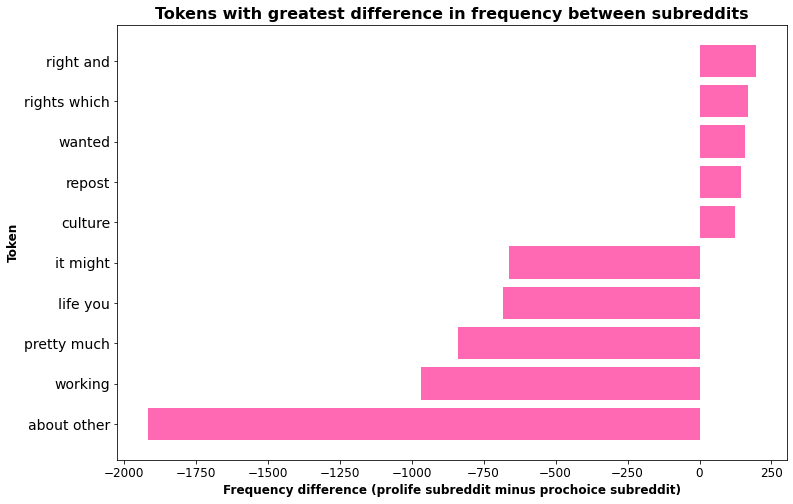

In [39]:
plt.figure(figsize=(12,8))

font_title = {'weight' : 'bold',
        'size': 16}

font_label = {'weight' : 'bold',
        'size' : 12}


plt.barh(greatest_diffs.index, greatest_diffs['difference'], color='hotpink')
plt.title('Tokens with greatest difference in frequency between subreddits', fontdict=font_title)
plt.xlabel('Frequency difference (prolife subreddit minus prochoice subreddit)', fontdict=font_label)
plt.ylabel('Token', fontdict=font_label)
plt.tick_params(axis='y', labelsize=14)
plt.tick_params(axis='x', labelsize=12)
plt.xticks(range(-2000, 500, 250));

plt.savefig('../figures/token_differences.png')
#consulted: https://stackoverflow.com/questions/11379910/how-do-i-change-the-font-size-of-the-scale-in-matplotlib-plots

## Sentiment Analysis

In [40]:
# Sentiment analysis
from nltk.sentiment.vader import SentimentIntensityAnalyzer

In [41]:
sia = SentimentIntensityAnalyzer()

sia.polarity_scores(df['title'][2])

{'neg': 0.204, 'neu': 0.796, 'pos': 0.0, 'compound': -0.3182}

In [42]:
# inspo from NLP i lecture
def extract_compound_sentiment(text):
    scores = sia.polarity_scores(text)
    return scores['compound']

def extract_neg_sentiment(text):
    scores = sia.polarity_scores(text)
    return scores['neg']

def extract_pos_sentiment(text):
    scores = sia.polarity_scores(text)
    return scores['pos']

In [44]:
df['title_sentiment_compound'] = df['title'].map(extract_compound_sentiment)
df['sentiment_compound'] = df['all_text'].map(extract_compound_sentiment)
df['sentiment_neg'] = df['all_text'].map(extract_neg_sentiment)
df['sentiment_pos'] = df['all_text'].map(extract_pos_sentiment)
df.drop(columns = ['selftext_impute']).to_csv('../data/posts_and_sentiment_scores.csv')
df.head()

,title,selftext,author_fullname,created_utc,subreddit,prolife_or_not,selftext_impute,all_text,title_sentiment_compound,sentiment_compound,sentiment_neg,sentiment_pos
0,Jake here thinks we use abortion as a girls ni...,NaN,t2_h4yrdcak,1645731680,prochoice,0,,Jake here thinks we use abortion as a girls ni...,0.0000,0.0000,0.000,0.000
1,How Black Feminists Defined Abortion Rights—As...,NaN,t2_wkk8q,1645729017,prochoice,0,,How Black Feminists Defined Abortion Rights—As...,0.6597,0.6597,0.000,0.213
2,US-linked anti-abortion centre targeting women...,NaN,t2_bkt67o0k,1645714835,prochoice,0,,US-linked anti-abortion centre targeting women...,-0.3182,-0.3182,0.204,0.000
3,I catch myself sometimes looking for the proli...,Anyone else ever do that? I think *Pfb* (pro f...,t2_47mcn020,1645655368,prochoice,0,Anyone else ever do that? I think *Pfb* (pro f...,I catch myself sometimes looking for the proli...,0.0000,0.5859,0.057,0.129
4,France extends abortion limit to 14 weeks,NaN,t2_n6epl,1645650196,prochoice,0,,France extends abortion limit to 14 weeks,0.1280,0.1280,0.000,0.200


## How do the distributions of sentiment scores compare?

In [45]:
df[df['subreddit'] == 'prolife'][['sentiment_compound']].describe()

,sentiment_compound
count,4986.000000
mean,-0.049307
std,0.514276
min,-0.999900
25%,-0.458800
50%,0.000000
75%,0.340000
max,0.997800


In [47]:
df[df['subreddit'] == 'prochoice'][['sentiment_compound']].describe()

,sentiment_compound
count,5000.000000
mean,-0.088787
std,0.555959
min,-0.999900
25%,-0.557400
50%,0.000000
75%,0.325200
max,0.999800


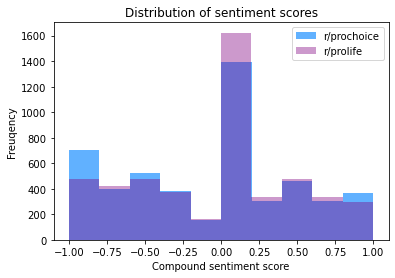

In [70]:
plt.hist(df[df['subreddit'] == 'prochoice'][['sentiment_compound']], color='dodgerblue', label='r/prochoice', alpha=.7)
plt.hist(df[df['subreddit'] == 'prolife'][['sentiment_compound']], color='purple', label='r/prolife', alpha=.4)

plt.title('Distribution of sentiment scores')
plt.xlabel('Compound sentiment score')
plt.ylabel('Freuqency')
plt.legend()

plt.savefig('../figures/sentiment_distribution.png');

array([[<AxesSubplot:title={'center':'sentiment_pos'}>]], dtype=object)

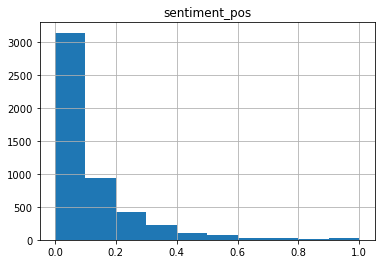

In [50]:
df[df['subreddit'] == 'prolife'][['sentiment_pos']].hist()

array([[<AxesSubplot:title={'center':'sentiment_neg'}>]], dtype=object)

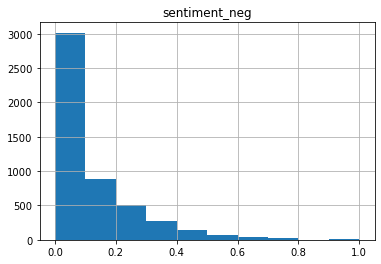

In [16]:
df[df['subreddit'] == 'prolife'][['sentiment_neg']].hist()

array([[<AxesSubplot:title={'center':'sentiment_neg'}>]], dtype=object)

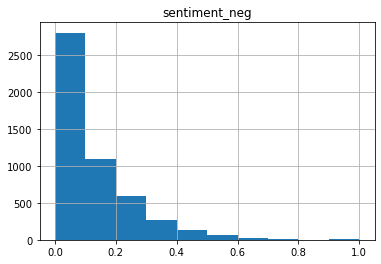

In [17]:
df[df['subreddit'] == 'prochoice'][['sentiment_neg']].hist()

In [52]:
## Posts over time
# convert UTC to GMT 
import time

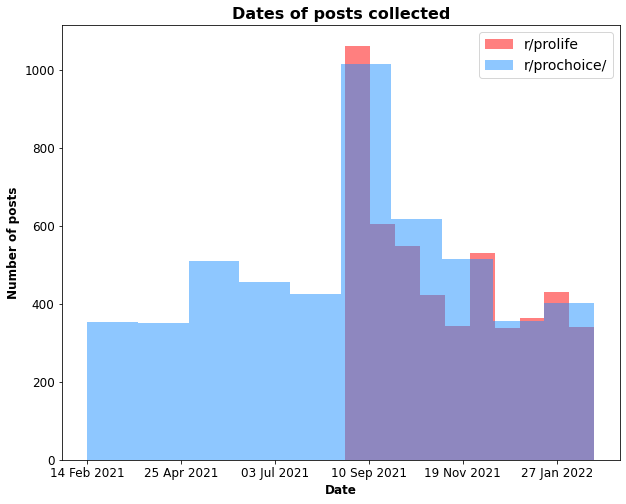

In [53]:
# Range of timestamps for x-axis labels
earliest = df['created_utc'].min()
latest = df['created_utc'].max()
earliest,latest

# Function to transform timestamps to dates
def utc_to_date(utc):
    return time.strftime('%d %b %Y', time.localtime(utc)) #source: https://www.epochconverter.com/

# Figure params
font_title = {'weight' : 'bold',
        'size': 16}
font_label = {'weight' : 'bold',
        'size' : 12}
ticks = range(earliest, latest, 6_000_000)

# Plot figure
plt.figure(figsize=(10,8))
plt.hist(df[df['subreddit'] == 'prolife']['created_utc'], color='red', alpha=.5, label='r/prolife')
plt.hist(df[df['subreddit'] == 'prochoice']['created_utc'], color='dodgerblue', alpha=.5, label='r/prochoice/')
plt.xticks(ticks =ticks, labels = [utc_to_date(i) for i in ticks])
plt.tick_params(labelsize=12)
plt.title('Dates of posts collected', fontdict=font_title)
plt.xlabel('Date', fontdict=font_label)
plt.ylabel('Number of posts', fontdict=font_label)
plt.legend(fontsize=14);
plt.savefig('../figures/postdates.png')